In [ ]:
# data was accessed from kaggle at the following link on 3-28-25
# https://www.kaggle.com/datasets/rtatman/188-million-us-wildfires
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import KFold, GridSearchCV, train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, RocCurveDisplay, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestRegressor
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
np.set_printoptions(precision=10, suppress=True)


os.chdir("c:/Users/AVILA/OneDrive/Documents/GitHub/Forest-fire-project")

df = pd.read_csv("fires_data.csv", low_memory = False)

ok so we have the id for the fire, the fire name, the year of the fire, the date and time the fire was discovered, the cause of the fire, location of the fire, fire size, and the state that the fire occurred in. 

what if we did just, using the state, cause, and day of the year, can we predict how large the fire is going to be?

I have a column that indicates the day of the year that the fire was identified, but I cannot use that as a numeric value because the algorithm will use that as an ordinal value. Instead, I convert the "doy" column (day of the year) to a season indicator of Spring, Summer, Fall, Winter, with an even split of 91 days.

In [2]:
fires = pd.DataFrame({"doy": df["DISCOVERY_DOY"],
            "year": df["FIRE_YEAR"],
            "cause_code": df["STAT_CAUSE_CODE"],
            "cause": df["STAT_CAUSE_DESCR"],
            "fire_size": df["FIRE_SIZE"],
            "longitude": df["LONGITUDE"],
            "latitude": df["LATITUDE"],
            "state": df["STATE"]})

fires["season"] = np.where(fires["doy"] < 91, "Q1", "Q2")
fires.loc[(fires["doy"] >=91*2) & (fires["doy"] < 91*3), "season"] = "Q3"
fires.loc[(fires["doy"] >= 91*3), "season"] = "Q4"
fires.head()

,doy,year,cause_code,cause,fire_size,longitude,latitude,state,season
0,33,2005,9.0,Miscellaneous,0.10,-121.005833,40.036944,CA,Q1
1,133,2004,1.0,Lightning,0.25,-120.404444,38.933056,CA,Q2
2,152,2004,5.0,Debris Burning,0.10,-120.735556,38.984167,CA,Q2
3,180,2004,1.0,Lightning,0.10,-119.913333,38.559167,CA,Q2
4,180,2004,1.0,Lightning,0.10,-119.933056,38.559167,CA,Q2


In [43]:
fires.groupby(["cause", "season"]).count().head(12)

doy   year  cause_code  fire_size  longitude  latitude  \
cause    season                                                             
Arson    Q1      92938  92938       92938      92938      92938     92938   
         Q2      85922  85922       85922      85922      85922     85922   
         Q3      50181  50181       50181      50181      50181     50181   
         Q4      52414  52414       52414      52414      52414     52414   
Campfire Q1      12239  12239       12239      12239      12239     12239   
         Q2      22936  22936       22936      22936      22936     22936   
         Q3      28196  28196       28196      28196      28196     28196   
         Q4      12768  12768       12768      12768      12768     12768   
Children Q1      15126  15126       15126      15126      15126     15126   
         Q2      23955  23955       23955      23955      23955     23955   
         Q3      13887  13887       13887      13887      13887     13887   
         Q4       8199   8199        8199       8199       8199      8199   

                 state  
cause    season         
Arson    Q1      92938  
         Q2      85922  
         Q3      50181  
         Q4      52414  
Campfire Q1      12239  
         Q2      22936  
         Q3      28196  
         Q4      12768  
Children Q1      15126  
         Q2      23955  
         Q3      13887  
         Q4       8199

<Axes: xlabel='Count', ylabel='cause'>

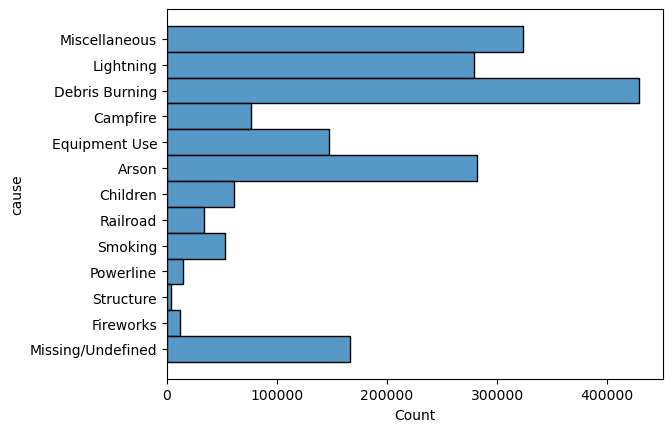

In [4]:
sns.histplot(fires, y = "cause")

In [38]:
mean_fire_size_state = pd.DataFrame({"mean": fires.groupby("state")["fire_size"].mean()})
std_fire_size_state = pd.DataFrame({"std": fires.groupby("state")["fire_size"].std()})
fire_size_state = mean_fire_size_state.merge(std_fire_size_state, how = "left", on = "state").reset_index().sort_values(by = "mean", ascending = False)
fire_size_state.head()


,state,mean,std
0,AK,2509.779198,19600.650646
33,NV,531.720650,5888.665139
13,ID,372.890482,5643.331940
32,NM,170.234318,2858.989052
51,WY,169.523555,2195.531021


In [44]:
fires_binary_copy = fires.copy()
fires_binary_copy = pd.get_dummies(fires_binary_copy, columns = ["state", "season"])
fires_binary_copy = fires_binary_copy.drop(["doy", "longitude", "latitude", "cause"], axis = 1)

# I am cutting down the size of the dataset due to the excessive time it takes to train the following models. 

fires_binary_copy = fires_binary_copy.sample(n = 100000, random_state = 20)

In [45]:
X_train, X_test, y_train, y_test = train_test_split(fires_binary_copy.loc[:, fires_binary_copy.columns != "fire_size"],
                                                    fires_binary_copy["fire_size"], 
                                                    test_size = .3, 
                                                    shuffle = True,
                                                    random_state = 20)

tree = DecisionTreeRegressor()
impurity_decrease = np.power(np.linspace(.0001, 10, 30), 2)
depth = np.linspace(3, 20, 17).astype(int)
parameters = {"min_impurity_decrease": impurity_decrease,
              "max_depth": depth}
kfcv = KFold()
cvgs = RandomizedSearchCV(tree, parameters, cv = kfcv, n_jobs = -1, n_iter = 50, random_state = 20)

cvgs.fit(X_train, y_train)
cvgs.best_estimator_

DecisionTreeRegressor(max_depth=3, min_impurity_decrease=0.47575268405469684)

In [46]:
#fitting the full decision tree on the training data validate using the test data.
tree = DecisionTreeRegressor(min_impurity_decrease = .475752684, max_depth = 3)
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)
y_pred_train = tree.predict(X_train)

train_mse = mean_squared_error(y_train, y_pred_train)
test_mse = mean_squared_error(y_test, y_pred)

print("mean training error in acres:", round(np.sqrt(train_mse), 2))
print("mean test error in acres:", round(np.sqrt(test_mse), 2))

mean training error in acres: 2004.95
mean test error in acres: 1993.27


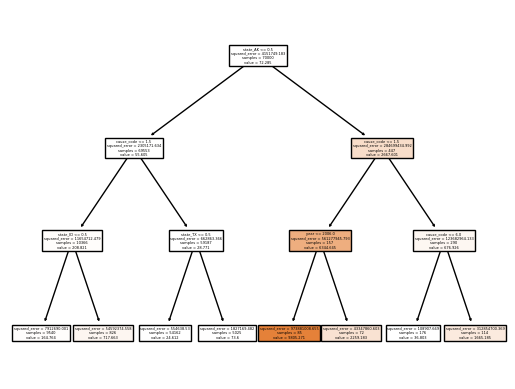

In [47]:
plot_tree(tree, filled = True, feature_names = X_train.columns)
plt.show()

The Decision Tree model as it currently stands is predicting with an average error of 1993.27 acres, which translates to approximately 3.12 square miles. 

Now we test to see how the decision tree does relative to a random forest model...

In [48]:
random_forest = RandomForestRegressor()
#the goal here is to do kfold cross validation, and we want to search over what regularization parameter for minimum split impurity gives us the best accuracy.
# to find the best parameter, we use grid search, and to use grid search, we need to create a dictionary of parameters.
# we use the same paramters for both min_impurity_decrease and max_depth as the decision tree model.

kfcv = KFold()
gscv = RandomizedSearchCV(random_forest, parameters, cv = kfcv, n_jobs = -1, n_iter = 50, random_state = 20)

gscv.fit(X_train, y_train)
gscv.best_estimator_

RandomForestRegressor(max_depth=3, min_impurity_decrease=34.364337694934605)

In [50]:
random_forest = RandomForestRegressor(max_depth = 3, min_impurity_decrease = 34.36433769)
random_forest.fit(X_train, y_train)
y_pred_train_rf = random_forest.predict(X_train)
y_pred_test_rf = random_forest.predict(X_test)

train_mse_rf = mean_squared_error(y_train, y_pred_train_rf)
test_mse_rf = mean_squared_error(y_test, y_pred_test_rf)

print("mean training error in acres:", round(np.sqrt(train_mse_rf), 2))
print("mean test error in acres:", round(np.sqrt(test_mse_rf), 2))

mean training error in acres: 2002.45
mean test error in acres: 1997.16
